In [3]:
import numpy as np
import tensorflow as tf
from utility_functions import *
import matplotlib.pyplot as plt
import seaborn as sns

In [4]:
# Define the function for four branches

def g_1(X1,X2):
    return 3 + 0.1*(X1-X2)**2-(X1+X2)/np.sqrt(2)
    
def g_2(X1,X2):
    return 3 + 0.1*(X1-X2)**2+(X1+X2)/np.sqrt(2)

    
def g_3(X1,X2, k = 6):
    return (X1-X2)+k/np.sqrt(2)

def g_4(X1,X2, k = 6):
    return (X2-X1)+k/np.sqrt(2)

    
def generate_y(X1,X2, k =6):
    
    g1 = g_1(X1,X2)
    g2 = g_2(X1,X2)
    g3 = g_3(X1,X2)
    g4 = g_4(X1,X2)
    g6 = np.minimum(g1,g2)
    
    g5 = np.minimum(g3,g4)
    g = np.minimum(g5,g6)
    y = (g>0).astype('uint8')

    return y

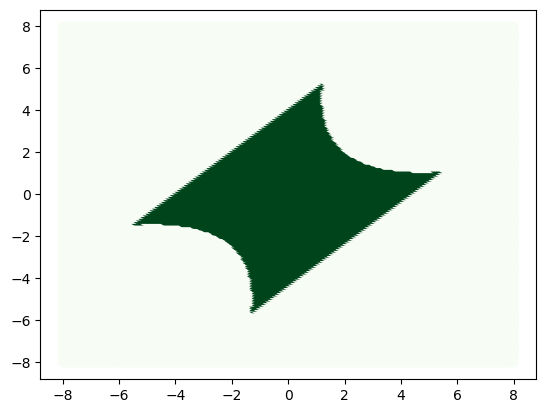

In [5]:
x = np.linspace(-8, 8, 200)
y = np.linspace(-8, 8, 200)
X1,X2 = np.meshgrid(x,y)
X1 = np.reshape(X1,[-1,1])
X2 = np.reshape(X2,[-1,1])

# Plot the decision surface
fig = plt.figure()
ax1 = fig.add_subplot(111)
ax1.scatter(X1,X2, c=generate_y(X1,X2), label='decision boundary',cmap='Greens')


In [6]:
# Grid the domain uniformally, and then random select subsets from these data as the training data  

Data =np.concatenate([X1,X2],axis = -1)
np.random.shuffle(Data)
X = Data[:300,:]

Y = generate_y(X[:,0],X[:,1])
test_X = Data
test_Y =  generate_y(test_X[:,0],test_X[:,1])

In [7]:
class BMF_loss(tf.keras.losses.Loss):
    def __init__(self, coeff, beta_func = 0):
        super().__init__()
        self.coeff = coeff
        self.beta_func = beta_func
    def call(self, y_true, y_pred):
        #
        inp = y_true[:,1:]
        y_true = y_true[:,0]
        
        # add a small number to avoid alpha = 0
        alphas = tf.math.exp(y_pred)+1.0e-8
        betas = tf.ones_like(y_pred) * self.beta_func(inp)
        a_ans = tf.gather(alphas,axis=-1, indices = tf.cast(y_true,'int32'), batch_dims = 1)
        a_zero = tf.math.reduce_sum(alphas,-1)
        beta_zero = tf.math.reduce_sum(betas,-1)
        
        l1_loss = tf.math.digamma(a_ans) - tf.math.digamma(a_zero)
        loss1 = tf.math.lgamma(a_zero) - tf.math.reduce_sum(tf.math.lgamma(alphas), -1)
        loss1 += -tf.math.lgamma(beta_zero) + tf.math.reduce_sum(tf.math.lgamma(betas), -1)
        loss2 = tf.math.reduce_sum((alphas - betas)*(tf.math.digamma(alphas) - tf.math.digamma(tf.expand_dims(a_zero,-1))),-1)

        kl_loss = loss1 + loss2
        loss = tf.math.reduce_mean(self.coeff*kl_loss - l1_loss)
        return loss

In [10]:
coeff = 3
activation = 'relu'



def prior_exp(beta_func,coeff = coeff):
    # Use two layers with 50 neurons.
    model = tf.keras.Sequential ()
    model.add(tf.keras.layers.Dense(50, activation=activation, use_bias=True, input_shape=(2,)))
    model.add(tf.keras.layers.Dense(50, activation=activation ,use_bias=True,))
    model.add(tf.keras.layers.Dense(2))
    model.compile(optimizer = tf.keras.optimizers.Adam(), loss = BMF_loss(coeff = coeff, beta_func = beta_func))    
    model.fit(X,np.append(tf.expand_dims(Y, axis = -1),X[:,:],axis = 1),epochs = 200, verbose = 0)
    
    # Plot the data and print confusion matrix
    predicted = tf.math.argmax(model(test_X),axis = -1)
    actual = test_Y
    TP = tf.math.count_nonzero(predicted * actual)
    TN = tf.math.count_nonzero((predicted - 1) * (actual - 1))
    FP = tf.math.count_nonzero(predicted * (actual - 1))
    FN = tf.math.count_nonzero((predicted - 1) * actual)
    print("Four tensor before represent TP,TN,FP,FN, respectively")
    print(TP)
    print(TN)
    print(FP)
    print(FN)
    result,xx,yy = draw_prediction(model, xlim = [-8,8], ylim = [-8,8], num = [200,200])
    # prediction = ((result[:,0]<0.9) & (0.1<result[:,0]))
    prediction = np.argmax(result, axis = -1)
   
    fig = plt.figure()
    ax1 = fig.add_subplot(111)
    ax1.scatter(xx,yy, c=prediction, label='decision boundary',cmap='Greens')
    ax1.scatter(X[:,0],X[:,1], c=Y, label='data')
    return np.array([TP, TN, FP, FN]), result


Four tensor before represent TP,TN,FP,FN, respectively
tf.Tensor(5985, shape=(), dtype=int64)
tf.Tensor(32972, shape=(), dtype=int64)
tf.Tensor(396, shape=(), dtype=int64)
tf.Tensor(647, shape=(), dtype=int64)


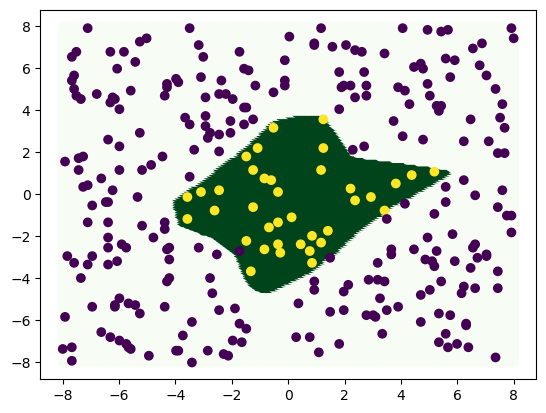

In [11]:
def low_prior(x):
    return [0.00002,0.00002]
cf_matrix, result = prior_exp(low_prior)

Four tensor before represent TP,TN,FP,FN, respectively
tf.Tensor(6413, shape=(), dtype=int64)
tf.Tensor(32312, shape=(), dtype=int64)
tf.Tensor(1056, shape=(), dtype=int64)
tf.Tensor(219, shape=(), dtype=int64)


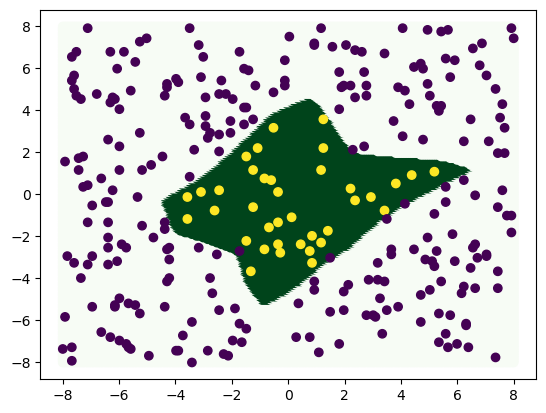

In [21]:
def low_type2_error(x):
    batch_size = tf.shape(x)[0]    
    b_cls1 = 0.003*tf.math.exp(-tf.math.reduce_sum(x**2, axis = -1))
    b_cls1 = tf.expand_dims(b_cls1,axis = -1)
    b_cls2 = tf.fill([batch_size,1],0.03)
    return tf.concat([b_cls1, b_cls2],axis = -1)
cf_matrix, result = prior_exp(low_type2_error)

Four tensor before represent TP,TN,FP,FN, respectively
tf.Tensor(5506, shape=(), dtype=int64)
tf.Tensor(33313, shape=(), dtype=int64)
tf.Tensor(55, shape=(), dtype=int64)
tf.Tensor(1126, shape=(), dtype=int64)


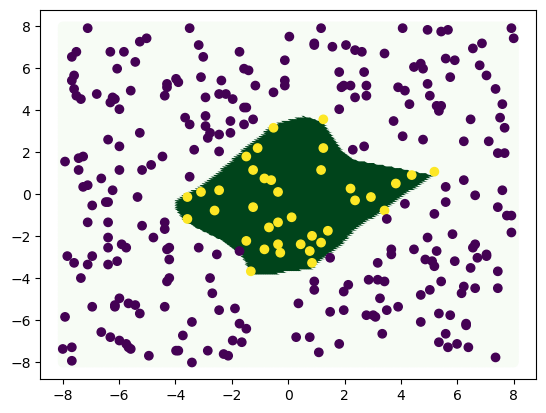

In [20]:
def low_type1_error(x):
    batch_size = tf.shape(x)[0]    
    b_cls1 = 0.003*tf.math.reduce_sum(x**2, axis = -1)
    b_cls1 = tf.expand_dims(b_cls1,axis = -1)
    b_cls2 = tf.fill([batch_size,1],0.003)
    return tf.concat([b_cls1, b_cls2],axis = -1)
cf_matrix, result = prior_exp(low_type1_error)